# Link Prediction

Note: taskRelations changed to taskStatusRelations (instantiates, runs, completes, ....), taskDataRelations (creates, references, validates, ...) and accessRelations (allocates, ...)

# Imports

In [1]:
import pandas as pd
import seaborn as sns

import networkx as nx
import numpy as np
from sklearn.pipeline import make_pipeline
import karateclub
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from util import cv_score_link_prediction
from link_prediction import LinkPredictor, LinkPredictionWrapper, LinkDecoderModule, NetworkxLinkPredictor,\
NeighTypeVectorizer, CentralityTransformer
import nn
import os

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
Using backend: pytorch


# Data Acquisition

In [2]:
g = nx.read_gml("team_ip_1.gml")

# Baselines

## Dummy Classifier

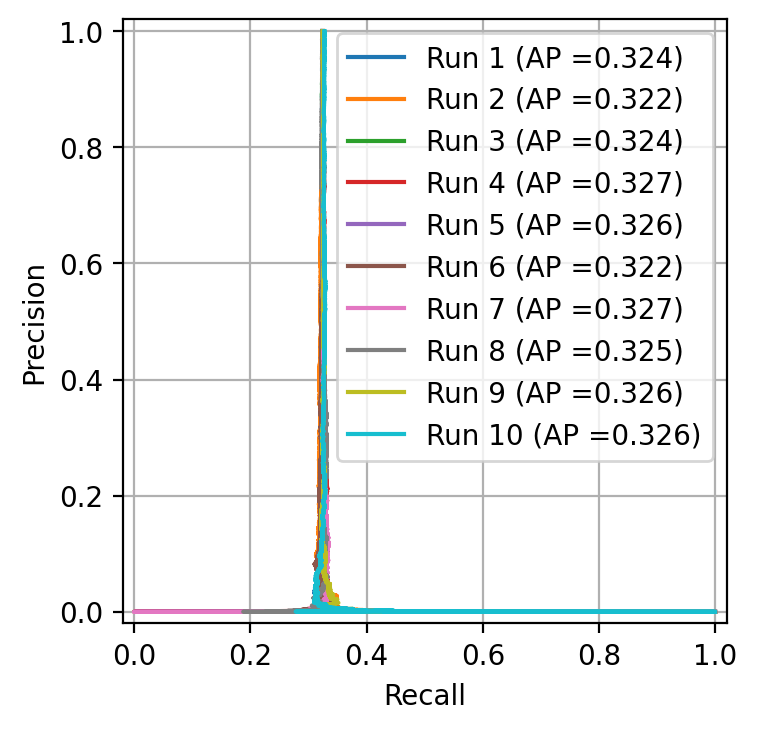

                          mean    std
average_precision_score  0.325  0.002
roc_auc_score            0.501  0.002


In [3]:
from sklearn.dummy import DummyClassifier

class DummyLinkPred():
    def fit(self, *_, **__):
        return self
    
    def predict_proba(self, X, X_test):
        return np.random.uniform(0, 1, size=X_test.number_of_edges())
    
    def predict(self, X, X_test):
        return self.predict_proba(X, X_test) >= 0.5
                

cv_score_link_prediction(DummyLinkPred(), g, plot_pr_curve=True);

## Node Centrality Features

### In- and Out-Degree

0.419
0.421
0.42
0.418
0.42
0.419
0.422
0.42
0.417
0.419


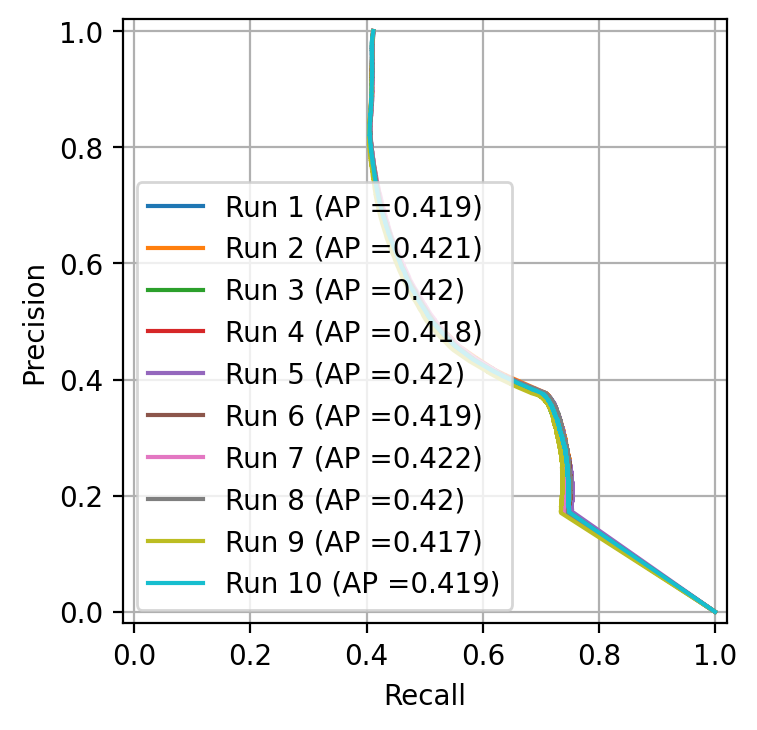

average_precision_score: 0.419 +- 0.0013


In [12]:
node_embedder = make_pipeline(CentralityTransformer(centralities=(nx.in_degree_centrality, 
                                                                            nx.out_degree_centrality)),
                              StandardScaler())
link_pred = LinkPredictionWrapper(encoder=node_embedder)
cv_score_link_prediction(link_pred, g, verbose=True, plot_pr_curve=True);

### More Centrality Features

0.413
0.415
0.414
0.413
0.415
0.413
0.415
0.415
0.412
0.414


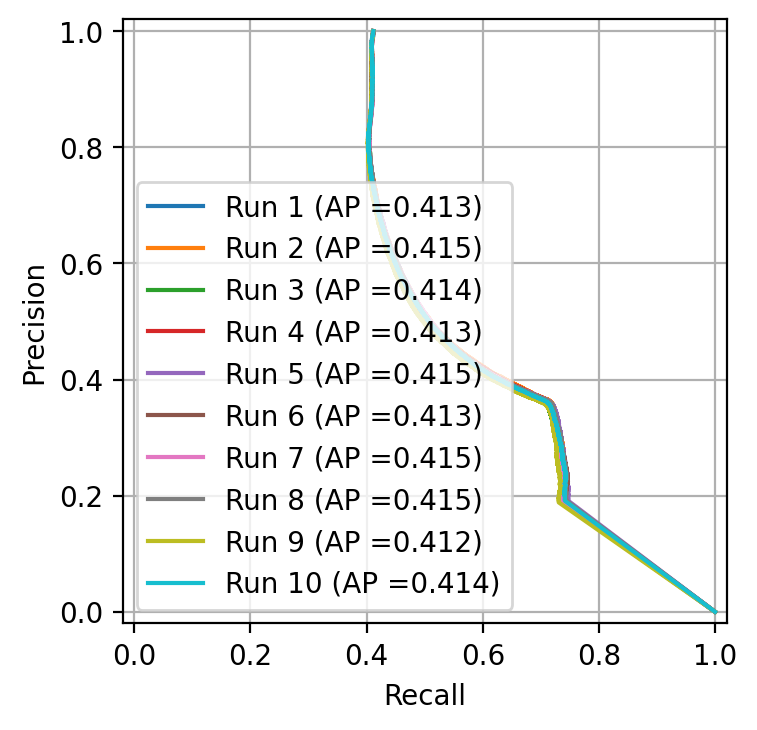

average_precision_score: 0.414 +- 0.0011


In [13]:
node_embedder = make_pipeline(CentralityTransformer(centralities=(nx.in_degree_centrality, 
                                                                  nx.out_degree_centrality, 
                                                                  nx.eigenvector_centrality_numpy, 
                                                                  nx.pagerank_scipy)),
                              StandardScaler())
link_pred = LinkPredictionWrapper(encoder=node_embedder)
cv_score_link_prediction(link_pred, g, verbose=True, plot_pr_curve=True);

0.517
0.509
0.506
0.51
0.509
0.511
0.509
0.51
0.508
0.51


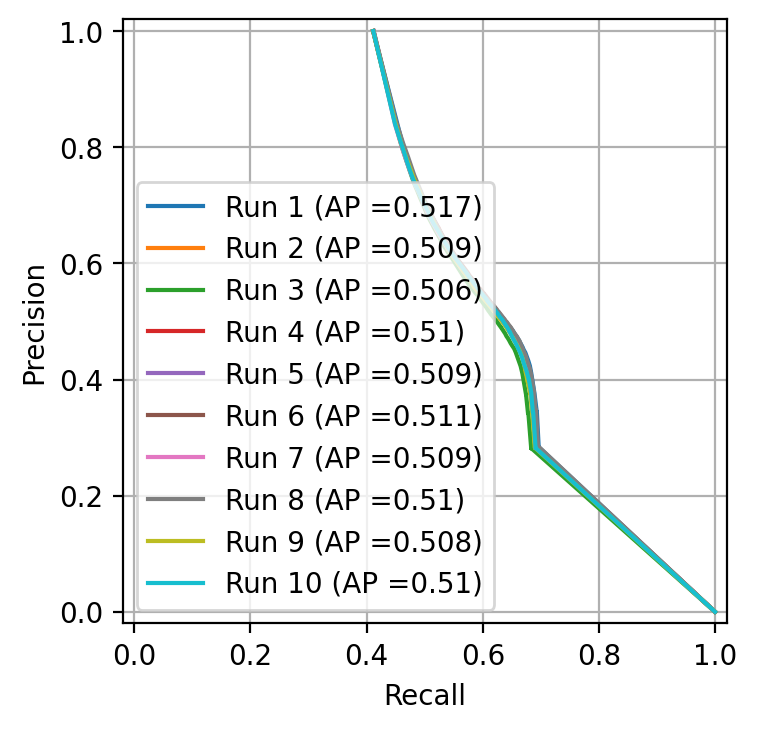

average_precision_score: 0.51 +- 0.0028


In [15]:
import importlib, link_prediction, util
importlib.reload(link_prediction)
importlib.reload(util)

node_embedder = make_pipeline(CentralityTransformer(centralities=(nx.in_degree_centrality, 
                                                                  nx.out_degree_centrality, 
                                                                  nx.eigenvector_centrality_numpy, 
                                                                  nx.pagerank_scipy)),
                              StandardScaler())
link_pred = link_prediction.LinkPredictionWrapper(encoder=node_embedder, decoder=RandomForestClassifier(n_jobs=6))
util.cv_score_link_prediction(link_pred, g, verbose=True, plot_pr_curve=True);

## Topological Algorithms

resource_allocation_index


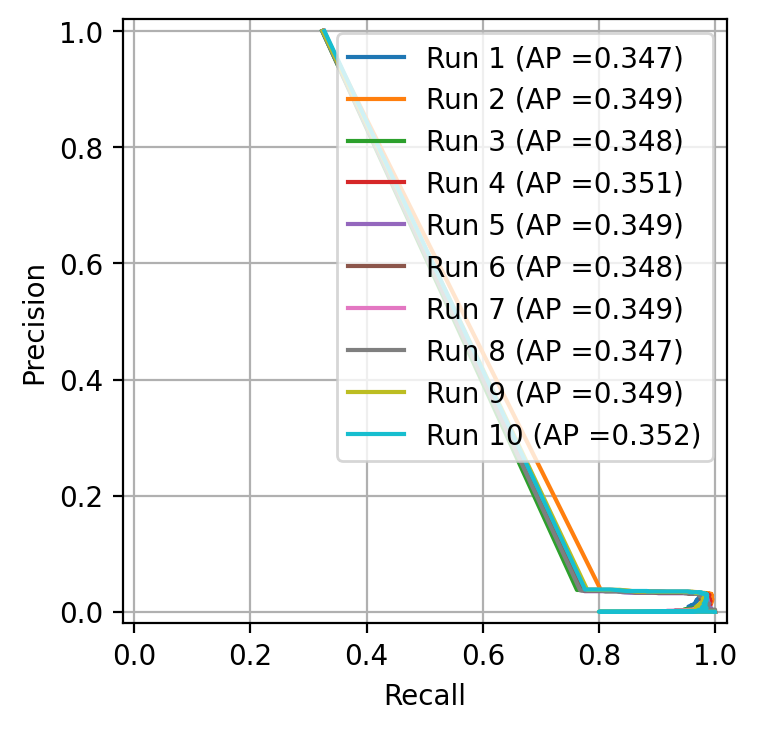

average_precision_score: 0.349 +- 0.0015
jaccard_coefficient


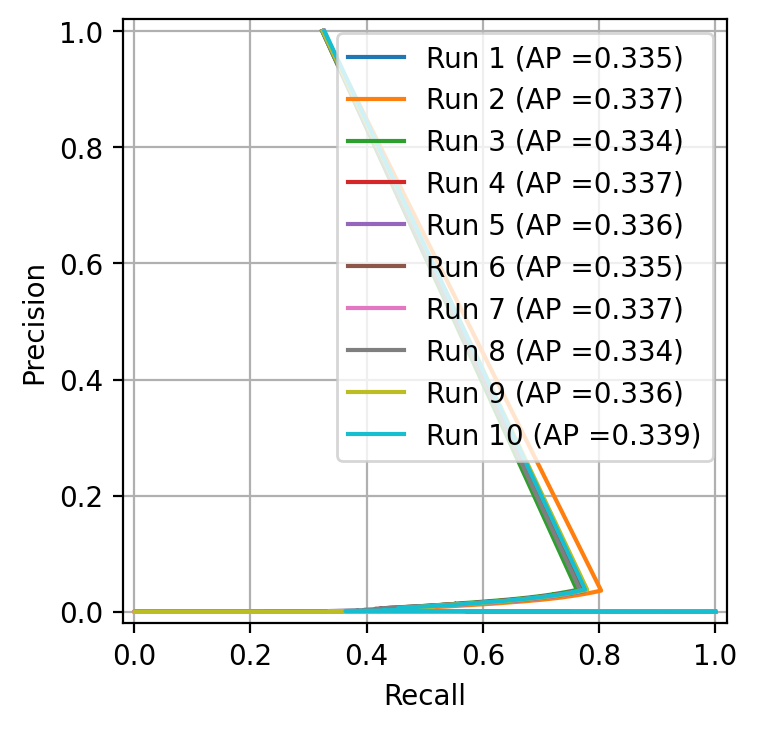

average_precision_score: 0.336 +- 0.0014
adamic_adar_index


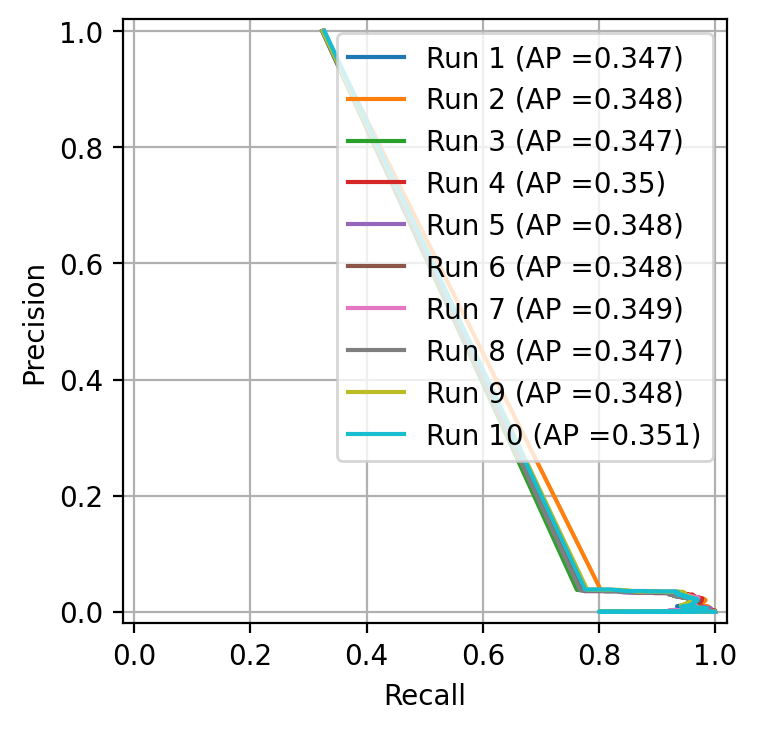

average_precision_score: 0.348 +- 0.0015
preferential_attachment


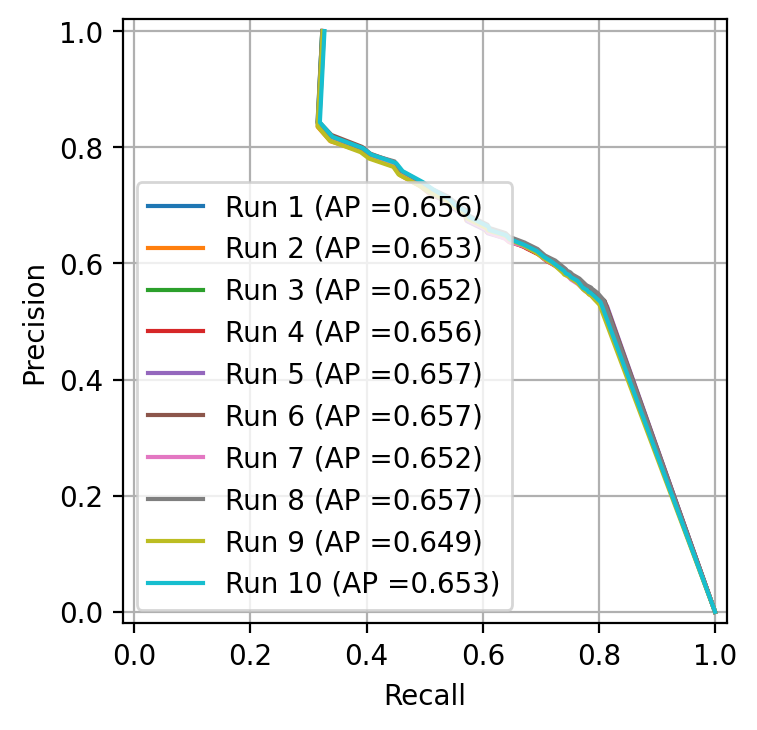

average_precision_score: 0.654 +- 0.0025


In [6]:
for algorithm in (nx.resource_allocation_index, nx.jaccard_coefficient, nx.adamic_adar_index,
                 nx.preferential_attachment):
    print(algorithm.__name__)
    nx_pred = NetworkxLinkPredictor(algorithm=algorithm, verbose=False)
    cv_score_link_prediction(nx_pred, g, verbose=False, plot_pr_curve=True);

## Bag of Types

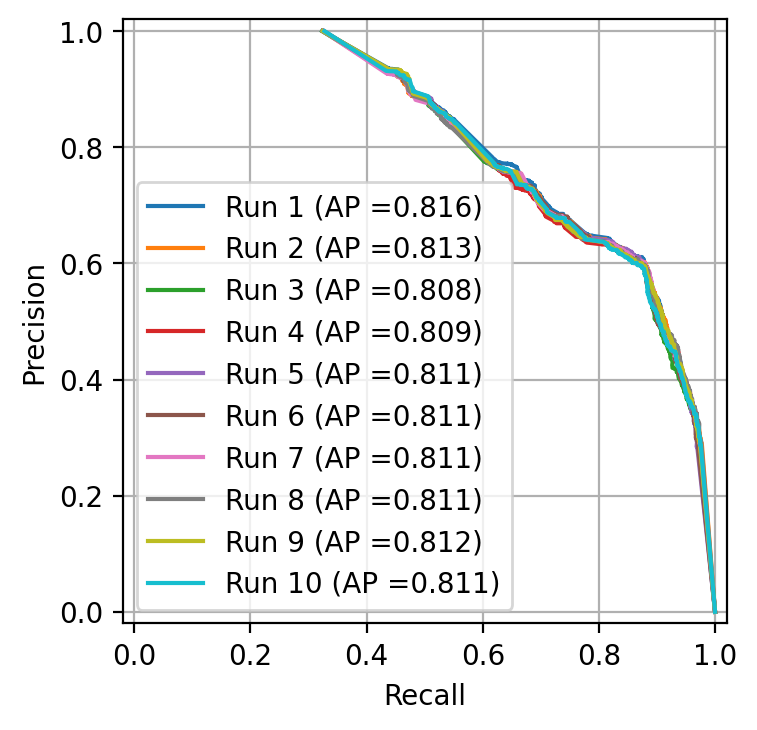

                          mean    std
average_precision_score  0.801  0.002
roc_auc_score            0.859  0.002


In [5]:
node_embedder = make_pipeline(NeighTypeVectorizer(), StandardScaler())
bot_rf = LinkPredictionWrapper(encoder=node_embedder)
bot_rf_scores = cv_score_link_prediction(bot_rf, g, plot_pr_curve=True);

## Walk-based Embeddings

DeepWalk
0.465
0.438
0.43
0.414
0.43
0.41
0.4
0.42
0.408
0.403


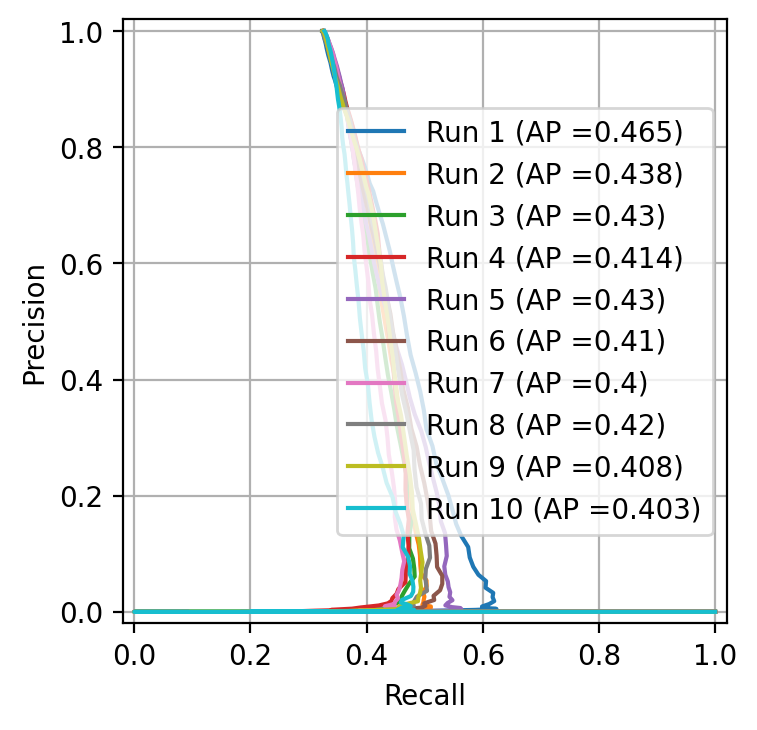

average_precision_score: 0.422 +- 0.0186
NodeSketch
0.707
0.701
0.707
0.709
0.705
0.709
0.705
0.702
0.698
0.71


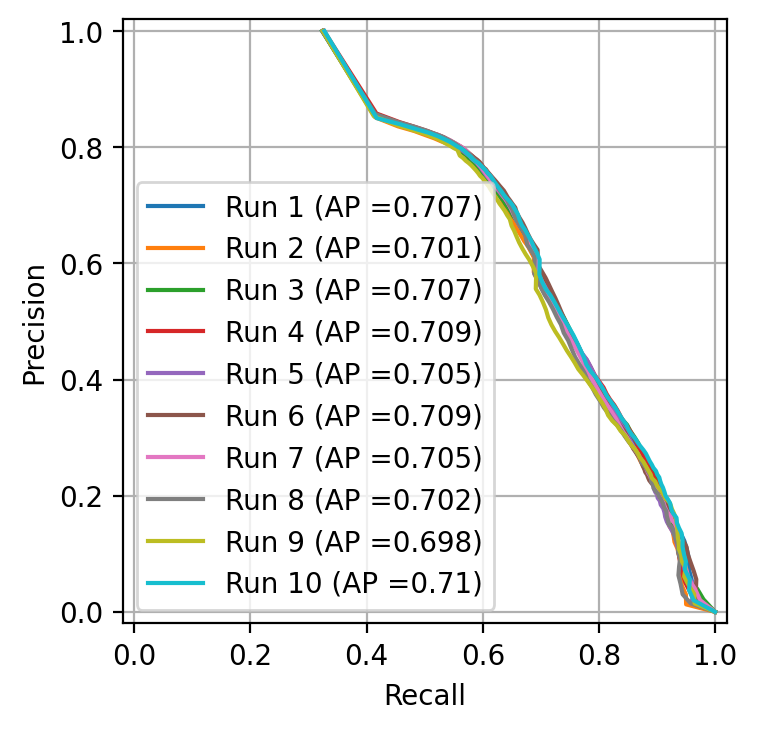

average_precision_score: 0.705 +- 0.0037
RandNE
0.677
0.675
0.673
0.674
0.672
0.673
0.672
0.679
0.674
0.677


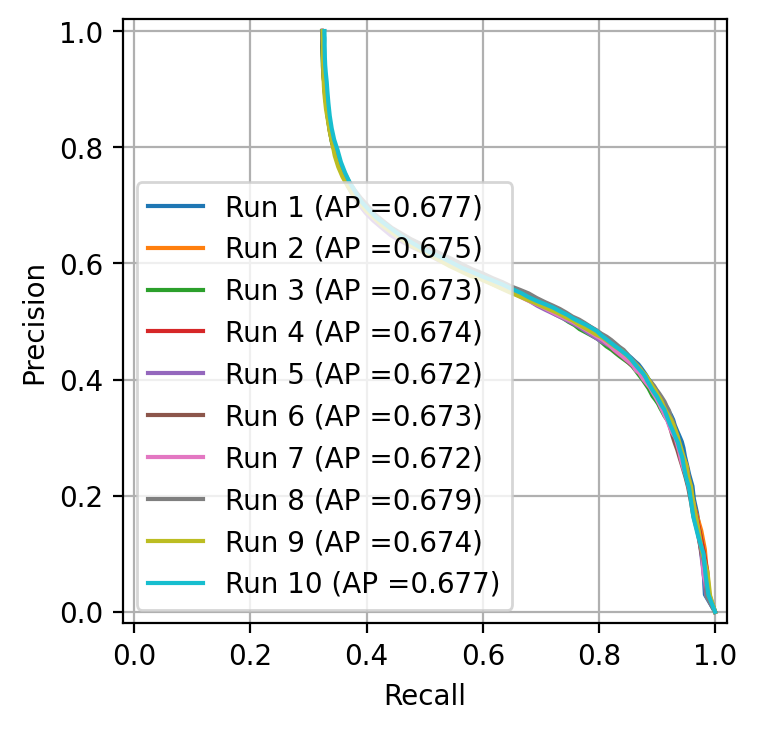

average_precision_score: 0.675 +- 0.0021
NetMF
0.742
0.746
0.727
0.752
0.765
0.75
0.704
0.748
0.715
0.729


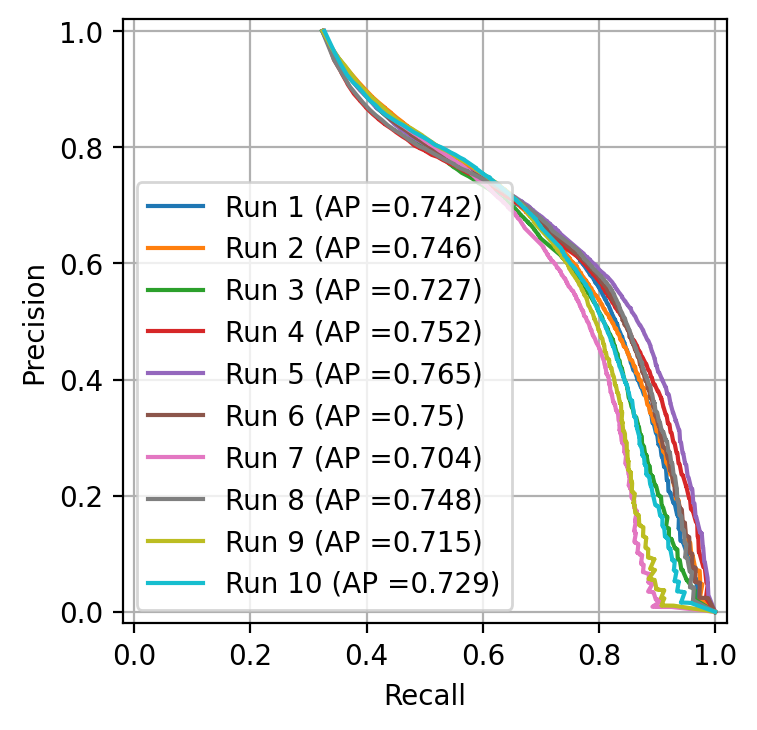

average_precision_score: 0.738 +- 0.0177
BoostNE


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.596


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.59


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.594


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.591


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.588


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.596


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.6


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.599


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.586


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.595


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


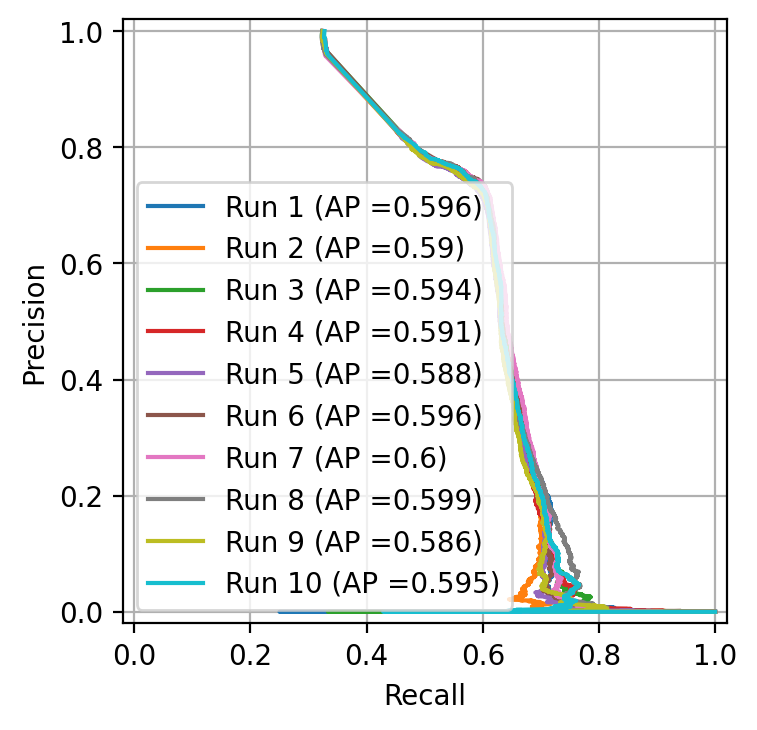

average_precision_score: 0.593 +- 0.0042


In [24]:
for algo in (karateclub.DeepWalk, karateclub.NodeSketch, karateclub.RandNE, karateclub.NetMF,
             karateclub.BoostNE, ):
    print(algo.__name__)
    pred = LinkPredictionWrapper(encoder=nn.KarateclubTransformer(algo()))
    cv_score_link_prediction(pred, g, plot_pr_curve=True)

### DeepWalk

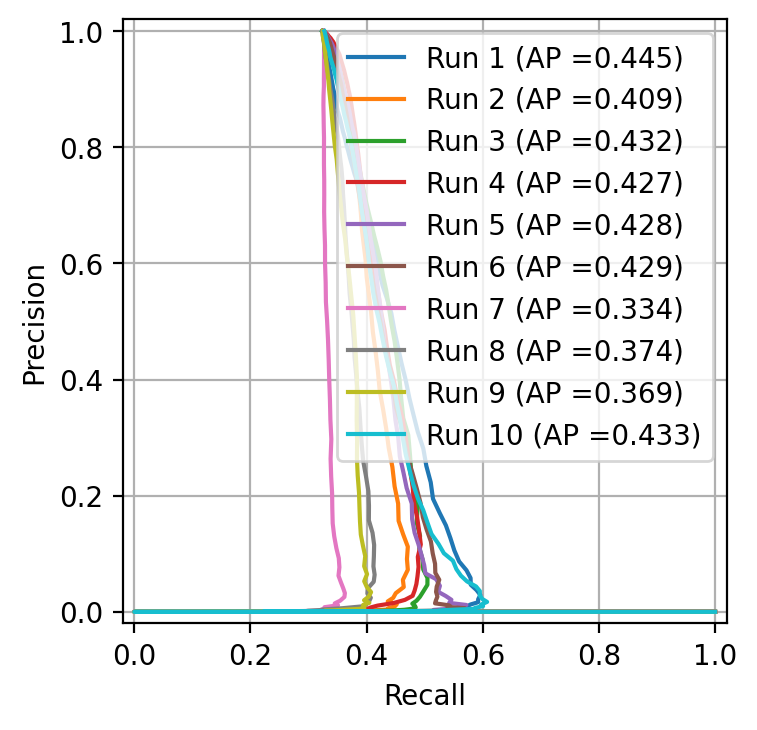

                          mean    std
average_precision_score  0.416  0.017
roc_auc_score            0.617  0.017


In [9]:
dw_pred = LinkPredictionWrapper(encoder=nn.KarateclubTransformer(karateclub.DeepWalk()))
dw_pred_scores = cv_score_link_prediction(dw_pred, g, plot_pr_curve=True)

### NetMF

average_precision_score: 0.742	roc_auc_score: 0.811
average_precision_score: 0.746	roc_auc_score: 0.815
average_precision_score: 0.727	roc_auc_score: 0.807
average_precision_score: 0.752	roc_auc_score: 0.804
average_precision_score: 0.765	roc_auc_score: 0.815
average_precision_score: 0.75	roc_auc_score: 0.812
average_precision_score: 0.704	roc_auc_score: 0.803
average_precision_score: 0.748	roc_auc_score: 0.808
average_precision_score: 0.715	roc_auc_score: 0.81
average_precision_score: 0.729	roc_auc_score: 0.808


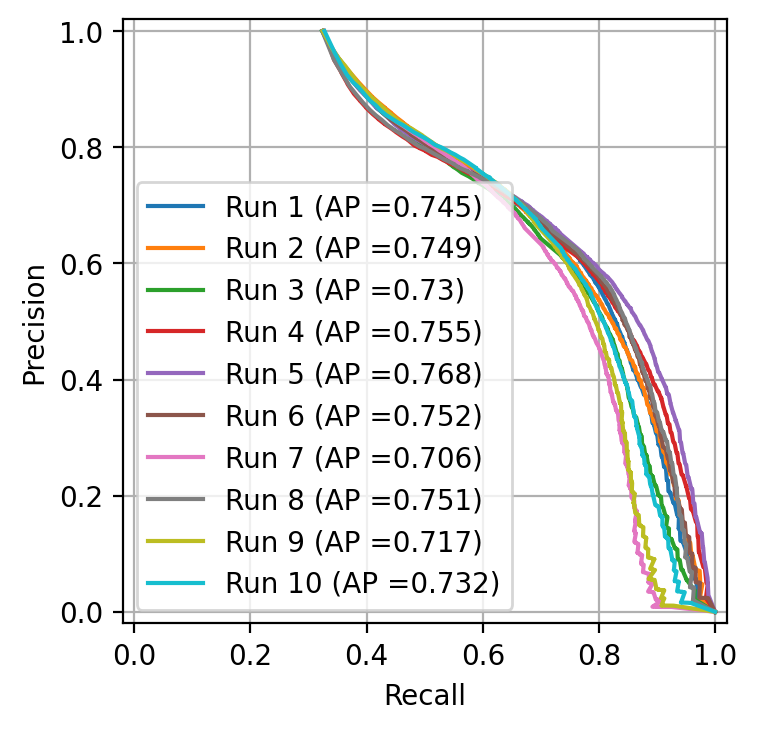

                          mean    std
average_precision_score  0.738  0.019
roc_auc_score            0.809  0.004


In [8]:
netmf_pred = LinkPredictionWrapper(encoder=nn.KarateclubTransformer(karateclub.NetMF()))
netmf_pred_scores = cv_score_link_prediction(netmf_pred, g, plot_pr_curve=True)

## MUSAE

In [7]:
musae_pred = LinkPredictionWrapper(encoder=nn.MUSAETransformer())
musae_pred_scores = cv_score_link_prediction(musae_pred, g, verbose=True, plot_pr_curve=True)

0.504
0.426
0.508
0.486
0.462
0.479
0.406
0.503
0.462
0.485
average_precision_score: 0.472 +- 0.0323


[0.5044977097804927,
 0.4256159254656624,
 0.5079060457497172,
 0.4855192347319648,
 0.4615668314964497,
 0.4794807839675148,
 0.40590965016433084,
 0.5029671710682353,
 0.4624806956996495,
 0.48467531348152204]

# GCN Models

## Architecture Modalities

### GCN

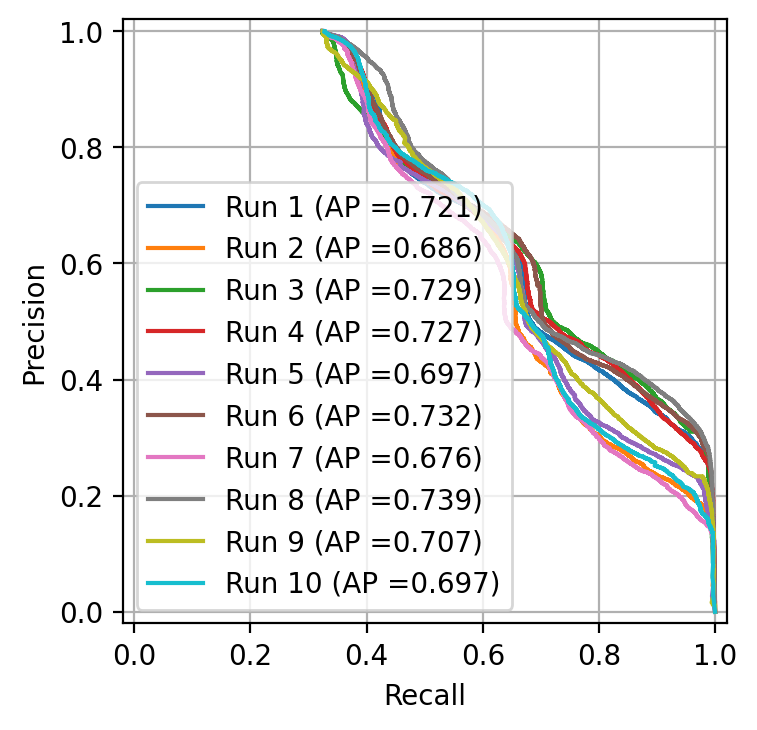

                             mean       std
average_precision_score  0.711042  0.021619
roc_auc_score            0.785216  0.012105


In [5]:
gcn = LinkPredictor(conv_cls=dgl.nn.GraphConv, skip_connections=False,
                                   decoder=LinkDecoderModule(asymmetric=False))

gcn_scores = cv_score_link_prediction(gcn, g, verbose=False, plot_pr_curve=True);

### A-GCN

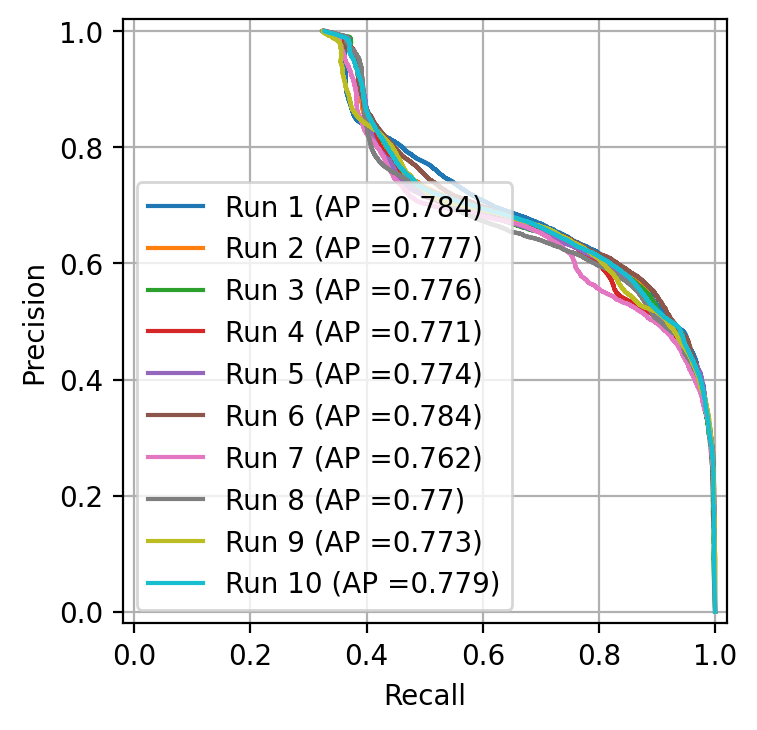

                          mean    std
average_precision_score  0.775  0.007
roc_auc_score            0.802  0.007


In [6]:
a_gcn = LinkPredictor(conv_cls=dgl.nn.GraphConv, skip_connections=False)

a_gcn_scores = cv_score_link_prediction(a_gcn, g, plot_pr_curve=True);

### ARes-GCN

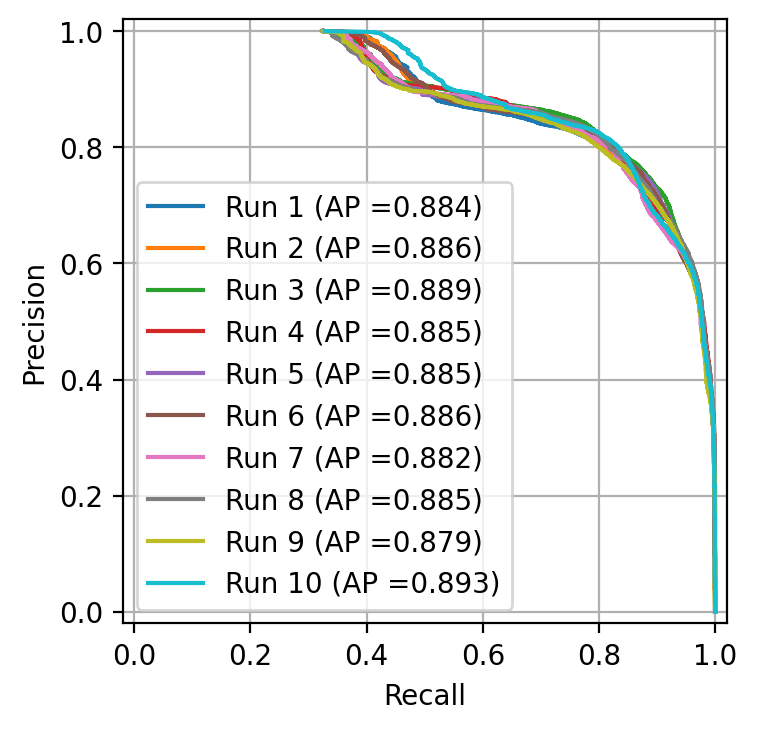

                          mean    std
average_precision_score  0.885  0.004
roc_auc_score            0.907  0.007


In [7]:
ares_gcn = LinkPredictor(conv_cls=dgl.nn.GraphConv)
ares_gcn_scores = cv_score_link_prediction(ares_gcn, g, plot_pr_curve=True);

### ABRes-GCN

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning

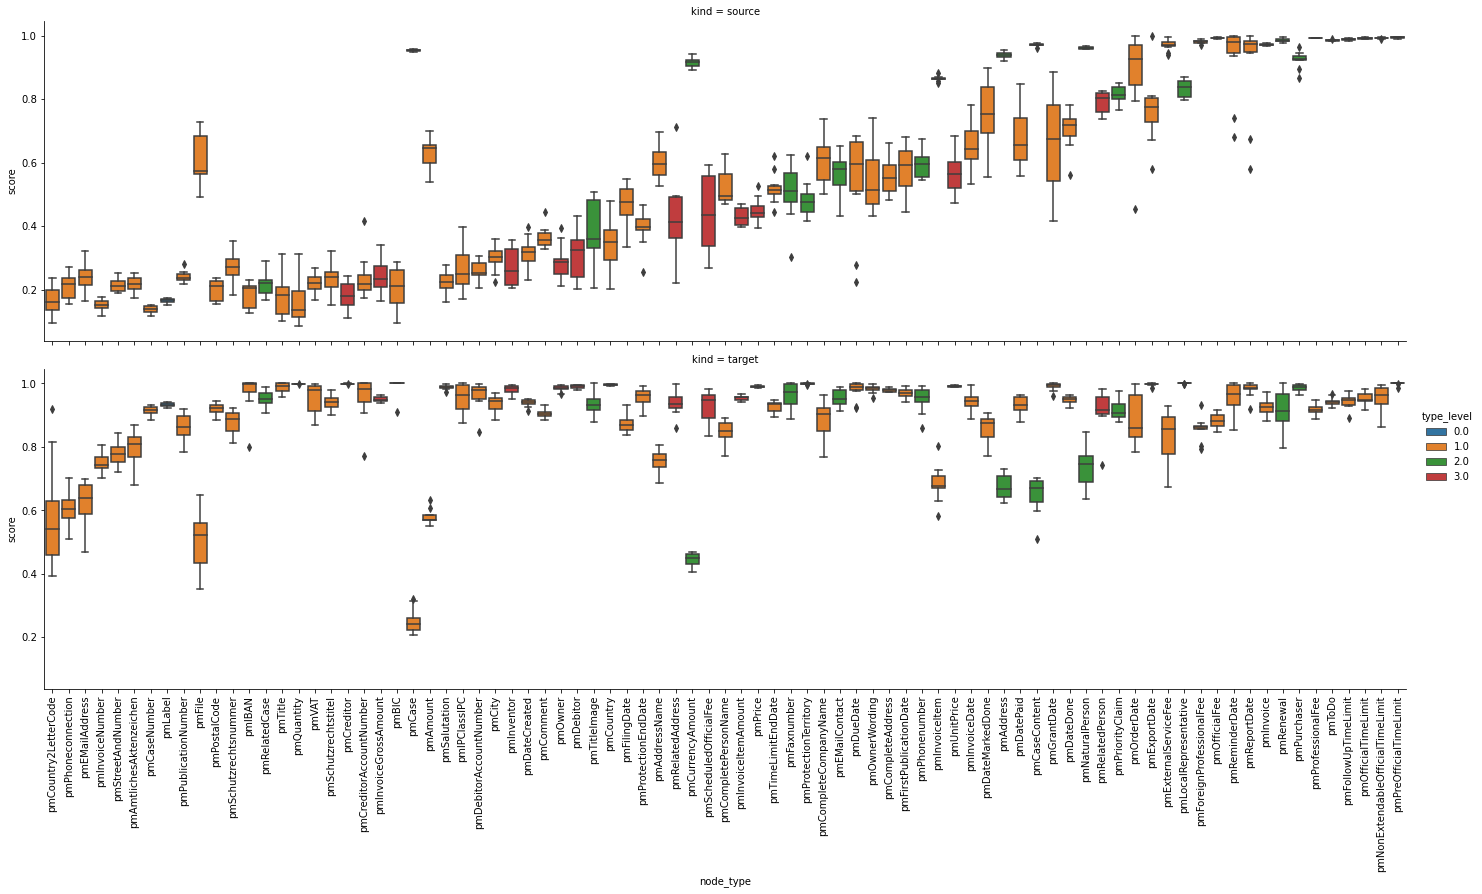

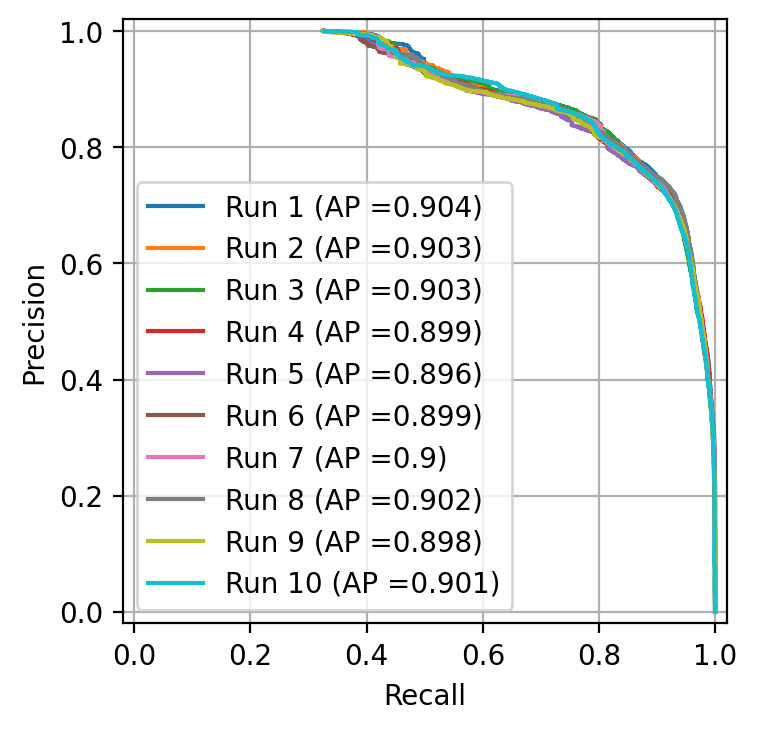

                          mean    std
average_precision_score  0.901  0.003
roc_auc_score            0.926  0.003


In [4]:
abres_gcn = LinkPredictor()
abres_gcn_scores = cv_score_link_prediction(abres_gcn, g, plot_pr_curve=True, plot_type_error=True)

### TatABRes-GCN

In [7]:
import nn

tatabres_gcn = LinkPredictor(conv_cls = nn.TypedMaskedGraphConv)
tatabres_gcn_scores = cv_score_link_prediction(tatabres_gcn, g, plot_pr_curve=True, plot_type_error=True)

DGLError: There are 0-in-degree nodes in the graph, output for those nodes will be invalid. This is harmful for some applications, causing silent performance regression. Adding self-loop on the input graph by calling `g = dgl.add_self_loop(g)` will resolve the issue. Setting ``allow_zero_in_degree`` to be `True` when constructing this module will suppress the check and let the code run.

### Comparison

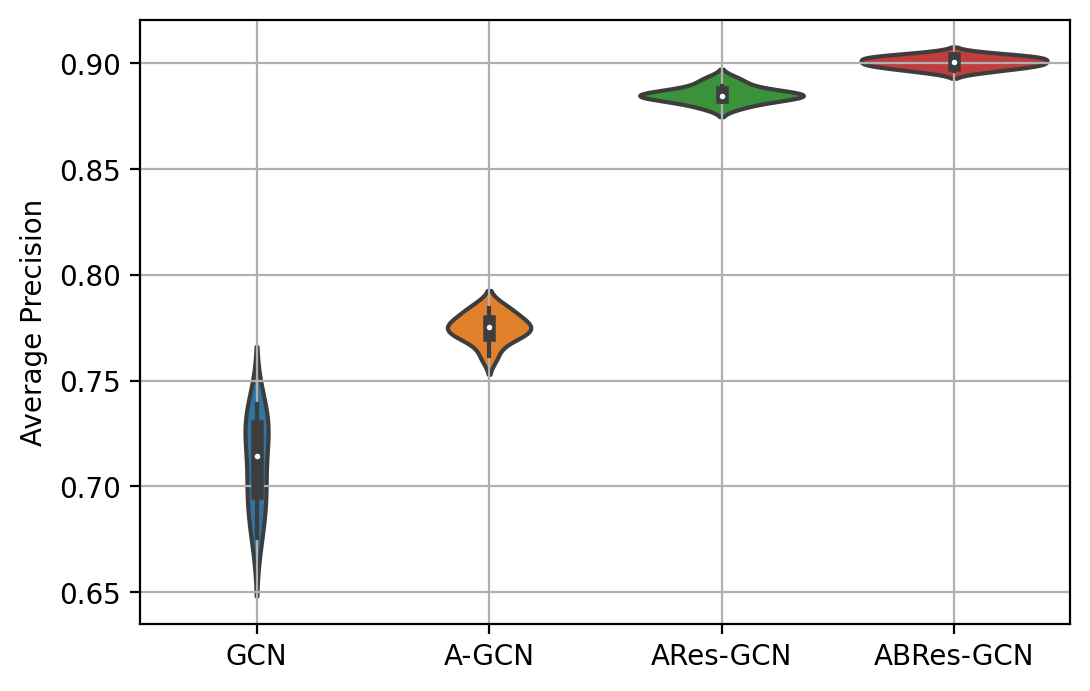

In [11]:
scores = [s['average_precision_score'] for s in [gcn_scores, a_gcn_scores, ares_gcn_scores, abres_gcn_scores]]
names = ['GCN', 'A-GCN', 'ARes-GCN', 'ABRes-GCN']
names = [[n]*len(scores) for n, scores in zip(names, scores)]

plt.figure(figsize=(6,4), dpi=200)
sns.violinplot(x=np.hstack(names), y=np.hstack(scores))
plt.grid(), plt.ylabel('Average Precision');

In [12]:
from scipy.stats import ttest_ind, ks_2samp

for i in range(1, len(scores)):
    print(names[i-1][0], names[i][0])
    print('\t', ttest_ind(scores[i-1], scores[i]))
    print('\t', ks_2samp(scores[i-1], scores[i]))

GCN A-GCN
	 Ttest_indResult(statistic=-8.921722968036075, pvalue=5.015004840789113e-08)
	 KstestResult(statistic=1.0, pvalue=1.0825088224469026e-05)
A-GCN ARes-GCN
	 Ttest_indResult(statistic=-45.304520556485784, pvalue=5.2814970228088634e-20)
	 KstestResult(statistic=1.0, pvalue=1.0825088224469026e-05)
ARes-GCN ABRes-GCN
	 Ttest_indResult(statistic=-10.684819016129854, pvalue=3.1922369567257307e-09)
	 KstestResult(statistic=1.0, pvalue=1.0825088224469026e-05)


## Ablation Studies

### Structure only

0.814
0.813
0.804
0.808
0.812
0.811
0.793
0.81
0.809
0.794


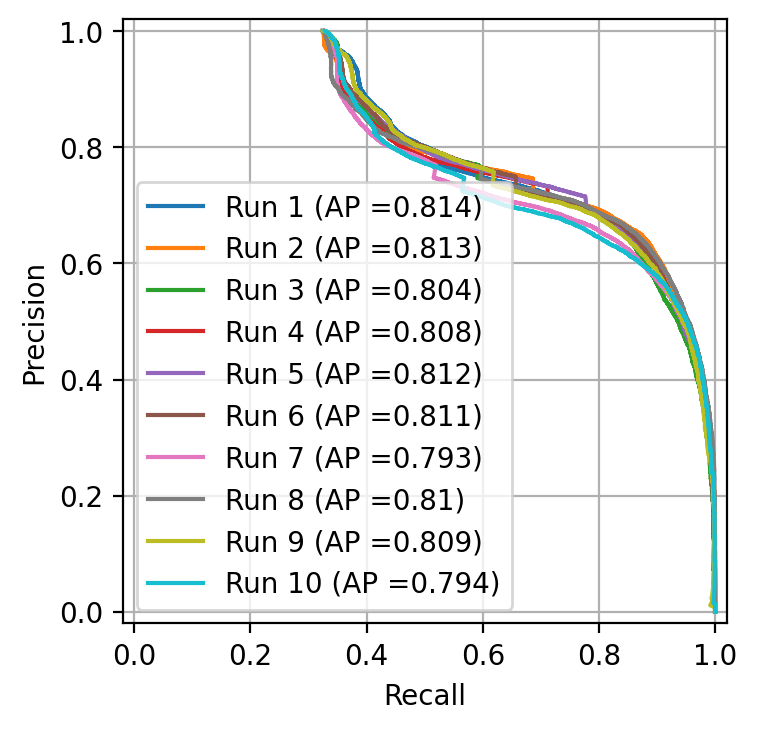

average_precision_score: 0.807 +- 0.0071


In [9]:
nx.set_node_attributes(g, values=1, name='dummy_label')
s_abres_gcn = LinkPredictor(node_feat_attr='dummy_label')
s_abres_gcn_scores = cv_score_link_prediction(s_abres_gcn, g, plot_pr_curve=True, verbose=True)

### GCN Layer Configuration

[16] False
average_precision_score: 0.874 +- 0.0016
[16, 16, 16] True
average_precision_score: 0.895 +- 0.002
[16, 16, 16] False
average_precision_score: 0.843 +- 0.0108
[16, 16, 16, 16, 16] True
average_precision_score: 0.89 +- 0.0023
[16, 16, 16, 16, 16] False
average_precision_score: 0.832 +- 0.0064
[16, 16, 16, 16, 16, 16, 16] True
average_precision_score: 0.882 +- 0.0078
[16, 16, 16, 16, 16, 16, 16] False
average_precision_score: 0.81 +- 0.0264
[32] False
average_precision_score: 0.887 +- 0.002
[32, 32, 32] True
average_precision_score: 0.903 +- 0.0016
[32, 32, 32] False
average_precision_score: 0.856 +- 0.0054
[32, 32, 32, 32, 32] True
average_precision_score: 0.901 +- 0.0025
[32, 32, 32, 32, 32] False
average_precision_score: 0.827 +- 0.0122
[32, 32, 32, 32, 32, 32, 32] True
average_precision_score: 0.896 +- 0.0021
[32, 32, 32, 32, 32, 32, 32] False
average_precision_score: 0.811 +- 0.015
[64] False
average_precision_score: 0.875 +- 0.0029
[64, 64, 64] True
average_precision_sco

<AxesSubplot:xlabel='layers', ylabel='score'>

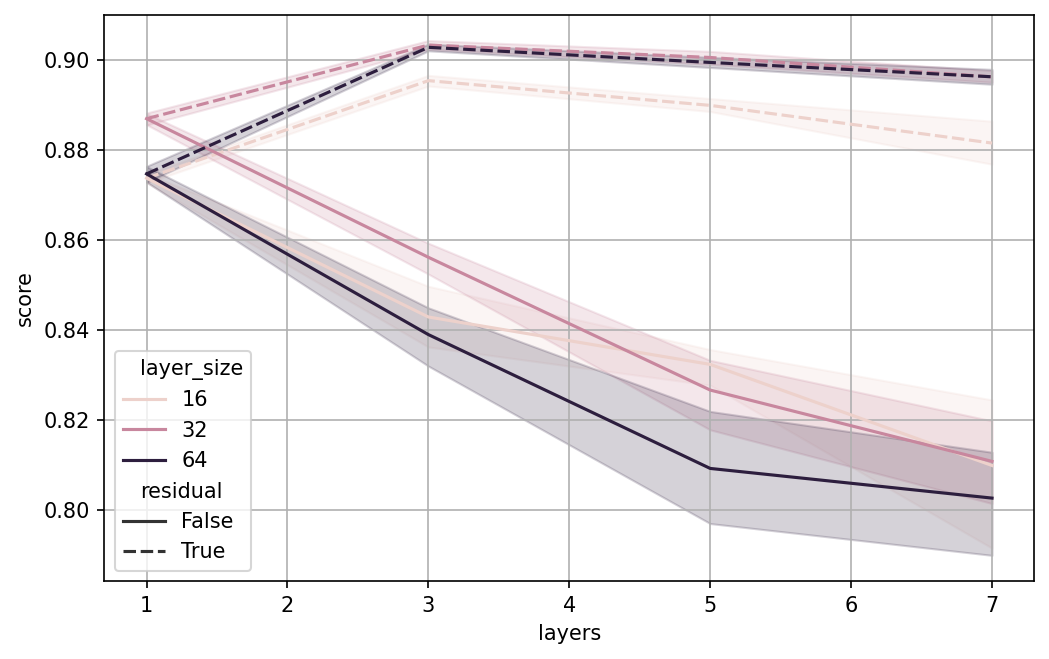

In [10]:
layer_df = []

for layer_size in (16, 32, 64):
    for num_layers in [1, 3, 5, 7]:
        for skip_connections in [True, False]:
            if skip_connections and num_layers < 3:
                continue
                
            est = LinkPredictor(layer_sizes = [layer_size]*num_layers, dropout=0.1, conv_cls = nn.BiGraphConv,
                               skip_connections=skip_connections)

            print([layer_size]*num_layers, skip_connections)
            scores = cv_score_link_prediction(est, g)['average_precision_score'];
            for score in scores:
                layer_df.append({'layers': num_layers, 'layer_size': layer_size, 'score':score,
                                'residual': skip_connections})

layer_df = pd.DataFrame(layer_df)
for layer_size, layers in np.unique(layer_df[['layer_size', 'layers']].values.T, axis=1).T:
    sub_df = layer_df[(layer_df.layer_size == layer_size) & (layer_df.layers == layers)]
    if True not in sub_df.residual.values:
        sub_df_ = sub_df.copy()
        sub_df_.residual = True
        layer_df = pd.concat([layer_df, sub_df_])

layer_df.to_csv('layer_configuration.csv')
plt.figure(figsize=(8, 5), dpi=150), plt.grid()
sns.lineplot(data=layer_df, x='layers', y='score', hue='layer_size', style='residual')

# Cora

In [5]:
from dgl.data import CoraGraphDataset
from dgl.nn import SAGEConv

cora = CoraGraphDataset()[0].to_networkx(node_attrs = ['feat', 'label'])


link_pred = LinkPredictor(verbose=True, nb_epochs=200, dense_layer_sizes = (), 
                                          layer_sizes = (16, 16),
                                          lr=0.01, conv_cls=SAGEConv, aggregator_type = 'mean', 
                                          node_feat_attr='feat', dropout=0, skip_connections=False,
                                         lr_scheduler_kwargs=dict(gamma= 1.0), weight_decay = 0,)

cv_score_link_prediction(link_pred, cora, verbose=True, test_size=.2,)

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
epoch 000 | lr 0.0100 | loss 0.7236 | train_score 0.5242
epoch 001 | lr 0.0100 | loss 0.6918 | train_score 0.5976
epoch 002 | lr 0.0100 | loss 0.6774 | train_score 0.6317
epoch 003 | lr 0.0100 | loss 0.6693 | train_score 0.6463
epoch 004 | lr 0.0100 | loss 0.6647 | train_score 0.6520
epoch 005 | lr 0.0100 | loss 0.6602 | train_score 0.6624
epoch 006 | lr 0.0100 | loss 0.6555 | train_score 0.6675
epoch 007 | lr 0.0100 | loss 0.6553 | train_score 0.6687
epoch 008 | lr 0.0100 | loss 0.6511 | train_score 0.6777
epoch 009 | lr 0.0100 | loss 0.6487 | train_score 0.6819
epoch 010 | lr 0.0100 | loss 0.6473 | train_score 0.6844
epoch 011 | lr 0.0100 | loss 0.6479 | train_score 0.6829
epoch 012 | lr 0.0100 | loss 0.6433 | train_score 0.

epoch 142 | lr 0.0100 | loss 0.5454 | train_score 0.8912
epoch 143 | lr 0.0100 | loss 0.5458 | train_score 0.8887
epoch 144 | lr 0.0100 | loss 0.5448 | train_score 0.8915
epoch 145 | lr 0.0100 | loss 0.5450 | train_score 0.8911
epoch 146 | lr 0.0100 | loss 0.5446 | train_score 0.8934
epoch 147 | lr 0.0100 | loss 0.5421 | train_score 0.9009
epoch 148 | lr 0.0100 | loss 0.5430 | train_score 0.8977
epoch 149 | lr 0.0100 | loss 0.5416 | train_score 0.9003
epoch 150 | lr 0.0100 | loss 0.5415 | train_score 0.9012
epoch 151 | lr 0.0100 | loss 0.5403 | train_score 0.9041
epoch 152 | lr 0.0100 | loss 0.5406 | train_score 0.9025
epoch 153 | lr 0.0100 | loss 0.5401 | train_score 0.9037
epoch 154 | lr 0.0100 | loss 0.5400 | train_score 0.9033
epoch 155 | lr 0.0100 | loss 0.5389 | train_score 0.9078
epoch 156 | lr 0.0100 | loss 0.5393 | train_score 0.9073
epoch 157 | lr 0.0100 | loss 0.5380 | train_score 0.9111
epoch 158 | lr 0.0100 | loss 0.5363 | train_score 0.9160
epoch 159 | lr 0.0100 | loss 0.

epoch 096 | lr 0.0100 | loss 0.5667 | train_score 0.8398
epoch 097 | lr 0.0100 | loss 0.5638 | train_score 0.8463
epoch 098 | lr 0.0100 | loss 0.5650 | train_score 0.8441
epoch 099 | lr 0.0100 | loss 0.5637 | train_score 0.8471
epoch 100 | lr 0.0100 | loss 0.5643 | train_score 0.8443
epoch 101 | lr 0.0100 | loss 0.5635 | train_score 0.8463
epoch 102 | lr 0.0100 | loss 0.5626 | train_score 0.8483
epoch 103 | lr 0.0100 | loss 0.5614 | train_score 0.8518
epoch 104 | lr 0.0100 | loss 0.5605 | train_score 0.8541
epoch 105 | lr 0.0100 | loss 0.5600 | train_score 0.8552
epoch 106 | lr 0.0100 | loss 0.5605 | train_score 0.8540
epoch 107 | lr 0.0100 | loss 0.5601 | train_score 0.8548
epoch 108 | lr 0.0100 | loss 0.5593 | train_score 0.8574
epoch 109 | lr 0.0100 | loss 0.5585 | train_score 0.8585
epoch 110 | lr 0.0100 | loss 0.5574 | train_score 0.8608
epoch 111 | lr 0.0100 | loss 0.5583 | train_score 0.8576
epoch 112 | lr 0.0100 | loss 0.5545 | train_score 0.8698
epoch 113 | lr 0.0100 | loss 0.

epoch 047 | lr 0.0100 | loss 0.5928 | train_score 0.7862
epoch 048 | lr 0.0100 | loss 0.5917 | train_score 0.7884
epoch 049 | lr 0.0100 | loss 0.5908 | train_score 0.7895
epoch 050 | lr 0.0100 | loss 0.5912 | train_score 0.7870
epoch 051 | lr 0.0100 | loss 0.5905 | train_score 0.7886
epoch 052 | lr 0.0100 | loss 0.5897 | train_score 0.7901
epoch 053 | lr 0.0100 | loss 0.5900 | train_score 0.7889
epoch 054 | lr 0.0100 | loss 0.5881 | train_score 0.7921
epoch 055 | lr 0.0100 | loss 0.5862 | train_score 0.7959
epoch 056 | lr 0.0100 | loss 0.5852 | train_score 0.7967
epoch 057 | lr 0.0100 | loss 0.5850 | train_score 0.7978
epoch 058 | lr 0.0100 | loss 0.5837 | train_score 0.7999
epoch 059 | lr 0.0100 | loss 0.5828 | train_score 0.8013
epoch 060 | lr 0.0100 | loss 0.5829 | train_score 0.8030
epoch 061 | lr 0.0100 | loss 0.5814 | train_score 0.8052
epoch 062 | lr 0.0100 | loss 0.5825 | train_score 0.8028
epoch 063 | lr 0.0100 | loss 0.5818 | train_score 0.8055
epoch 064 | lr 0.0100 | loss 0.

0.859
epoch 000 | lr 0.0100 | loss 0.7243 | train_score 0.5230
epoch 001 | lr 0.0100 | loss 0.6912 | train_score 0.5982
epoch 002 | lr 0.0100 | loss 0.6775 | train_score 0.6279
epoch 003 | lr 0.0100 | loss 0.6707 | train_score 0.6399
epoch 004 | lr 0.0100 | loss 0.6647 | train_score 0.6543
epoch 005 | lr 0.0100 | loss 0.6603 | train_score 0.6622
epoch 006 | lr 0.0100 | loss 0.6549 | train_score 0.6712
epoch 007 | lr 0.0100 | loss 0.6557 | train_score 0.6707
epoch 008 | lr 0.0100 | loss 0.6521 | train_score 0.6761
epoch 009 | lr 0.0100 | loss 0.6493 | train_score 0.6814
epoch 010 | lr 0.0100 | loss 0.6478 | train_score 0.6828
epoch 011 | lr 0.0100 | loss 0.6461 | train_score 0.6872
epoch 012 | lr 0.0100 | loss 0.6417 | train_score 0.6943
epoch 013 | lr 0.0100 | loss 0.6427 | train_score 0.6934
epoch 014 | lr 0.0100 | loss 0.6404 | train_score 0.6972
epoch 015 | lr 0.0100 | loss 0.6364 | train_score 0.7036
epoch 016 | lr 0.0100 | loss 0.6367 | train_score 0.7025
epoch 017 | lr 0.0100 | l

epoch 159 | lr 0.0100 | loss 0.5283 | train_score 0.9370
epoch 160 | lr 0.0100 | loss 0.5281 | train_score 0.9379
epoch 161 | lr 0.0100 | loss 0.5278 | train_score 0.9400
epoch 162 | lr 0.0100 | loss 0.5277 | train_score 0.9404
epoch 163 | lr 0.0100 | loss 0.5266 | train_score 0.9425
epoch 164 | lr 0.0100 | loss 0.5276 | train_score 0.9386
epoch 165 | lr 0.0100 | loss 0.5258 | train_score 0.9452
epoch 166 | lr 0.0100 | loss 0.5266 | train_score 0.9421
epoch 167 | lr 0.0100 | loss 0.5247 | train_score 0.9481
epoch 168 | lr 0.0100 | loss 0.5251 | train_score 0.9479
epoch 169 | lr 0.0100 | loss 0.5251 | train_score 0.9451
epoch 170 | lr 0.0100 | loss 0.5249 | train_score 0.9474
epoch 171 | lr 0.0100 | loss 0.5241 | train_score 0.9490
epoch 172 | lr 0.0100 | loss 0.5246 | train_score 0.9470
epoch 173 | lr 0.0100 | loss 0.5229 | train_score 0.9521
epoch 174 | lr 0.0100 | loss 0.5223 | train_score 0.9544
epoch 175 | lr 0.0100 | loss 0.5221 | train_score 0.9545
epoch 176 | lr 0.0100 | loss 0.

epoch 111 | lr 0.0100 | loss 0.5502 | train_score 0.8795
epoch 112 | lr 0.0100 | loss 0.5493 | train_score 0.8818
epoch 113 | lr 0.0100 | loss 0.5495 | train_score 0.8804
epoch 114 | lr 0.0100 | loss 0.5505 | train_score 0.8767
epoch 115 | lr 0.0100 | loss 0.5484 | train_score 0.8828
epoch 116 | lr 0.0100 | loss 0.5479 | train_score 0.8848
epoch 117 | lr 0.0100 | loss 0.5474 | train_score 0.8852
epoch 118 | lr 0.0100 | loss 0.5475 | train_score 0.8861
epoch 119 | lr 0.0100 | loss 0.5451 | train_score 0.8918
epoch 120 | lr 0.0100 | loss 0.5452 | train_score 0.8910
epoch 121 | lr 0.0100 | loss 0.5451 | train_score 0.8917
epoch 122 | lr 0.0100 | loss 0.5446 | train_score 0.8910
epoch 123 | lr 0.0100 | loss 0.5458 | train_score 0.8884
epoch 124 | lr 0.0100 | loss 0.5443 | train_score 0.8929
epoch 125 | lr 0.0100 | loss 0.5429 | train_score 0.8966
epoch 126 | lr 0.0100 | loss 0.5438 | train_score 0.8947
epoch 127 | lr 0.0100 | loss 0.5412 | train_score 0.9013
epoch 128 | lr 0.0100 | loss 0.

epoch 062 | lr 0.0100 | loss 0.5793 | train_score 0.8102
epoch 063 | lr 0.0100 | loss 0.5759 | train_score 0.8186
epoch 064 | lr 0.0100 | loss 0.5769 | train_score 0.8154
epoch 065 | lr 0.0100 | loss 0.5754 | train_score 0.8194
epoch 066 | lr 0.0100 | loss 0.5765 | train_score 0.8166
epoch 067 | lr 0.0100 | loss 0.5745 | train_score 0.8201
epoch 068 | lr 0.0100 | loss 0.5732 | train_score 0.8229
epoch 069 | lr 0.0100 | loss 0.5733 | train_score 0.8220
epoch 070 | lr 0.0100 | loss 0.5741 | train_score 0.8213
epoch 071 | lr 0.0100 | loss 0.5718 | train_score 0.8257
epoch 072 | lr 0.0100 | loss 0.5731 | train_score 0.8227
epoch 073 | lr 0.0100 | loss 0.5727 | train_score 0.8244
epoch 074 | lr 0.0100 | loss 0.5702 | train_score 0.8286
epoch 075 | lr 0.0100 | loss 0.5687 | train_score 0.8335
epoch 076 | lr 0.0100 | loss 0.5708 | train_score 0.8287
epoch 077 | lr 0.0100 | loss 0.5698 | train_score 0.8298
epoch 078 | lr 0.0100 | loss 0.5683 | train_score 0.8336
epoch 079 | lr 0.0100 | loss 0.

epoch 016 | lr 0.0100 | loss 0.6400 | train_score 0.6983
epoch 017 | lr 0.0100 | loss 0.6381 | train_score 0.7008
epoch 018 | lr 0.0100 | loss 0.6352 | train_score 0.7076
epoch 019 | lr 0.0100 | loss 0.6383 | train_score 0.7012
epoch 020 | lr 0.0100 | loss 0.6328 | train_score 0.7129
epoch 021 | lr 0.0100 | loss 0.6319 | train_score 0.7118
epoch 022 | lr 0.0100 | loss 0.6304 | train_score 0.7165
epoch 023 | lr 0.0100 | loss 0.6258 | train_score 0.7234
epoch 024 | lr 0.0100 | loss 0.6277 | train_score 0.7216
epoch 025 | lr 0.0100 | loss 0.6252 | train_score 0.7258
epoch 026 | lr 0.0100 | loss 0.6234 | train_score 0.7286
epoch 027 | lr 0.0100 | loss 0.6236 | train_score 0.7289
epoch 028 | lr 0.0100 | loss 0.6234 | train_score 0.7293
epoch 029 | lr 0.0100 | loss 0.6213 | train_score 0.7327
epoch 030 | lr 0.0100 | loss 0.6179 | train_score 0.7391
epoch 031 | lr 0.0100 | loss 0.6167 | train_score 0.7420
epoch 032 | lr 0.0100 | loss 0.6147 | train_score 0.7468
epoch 033 | lr 0.0100 | loss 0.

epoch 160 | lr 0.0100 | loss 0.5284 | train_score 0.9373
epoch 161 | lr 0.0100 | loss 0.5268 | train_score 0.9428
epoch 162 | lr 0.0100 | loss 0.5275 | train_score 0.9405
epoch 163 | lr 0.0100 | loss 0.5268 | train_score 0.9427
epoch 164 | lr 0.0100 | loss 0.5267 | train_score 0.9426
epoch 165 | lr 0.0100 | loss 0.5267 | train_score 0.9415
epoch 166 | lr 0.0100 | loss 0.5263 | train_score 0.9429
epoch 167 | lr 0.0100 | loss 0.5256 | train_score 0.9444
epoch 168 | lr 0.0100 | loss 0.5246 | train_score 0.9488
epoch 169 | lr 0.0100 | loss 0.5241 | train_score 0.9504
epoch 170 | lr 0.0100 | loss 0.5250 | train_score 0.9466
epoch 171 | lr 0.0100 | loss 0.5232 | train_score 0.9518
epoch 172 | lr 0.0100 | loss 0.5240 | train_score 0.9488
epoch 173 | lr 0.0100 | loss 0.5218 | train_score 0.9568
epoch 174 | lr 0.0100 | loss 0.5224 | train_score 0.9538
epoch 175 | lr 0.0100 | loss 0.5229 | train_score 0.9522
epoch 176 | lr 0.0100 | loss 0.5224 | train_score 0.9543
epoch 177 | lr 0.0100 | loss 0.

epoch 111 | lr 0.0100 | loss 0.5530 | train_score 0.8707
epoch 112 | lr 0.0100 | loss 0.5530 | train_score 0.8707
epoch 113 | lr 0.0100 | loss 0.5512 | train_score 0.8747
epoch 114 | lr 0.0100 | loss 0.5541 | train_score 0.8664
epoch 115 | lr 0.0100 | loss 0.5513 | train_score 0.8752
epoch 116 | lr 0.0100 | loss 0.5524 | train_score 0.8730
epoch 117 | lr 0.0100 | loss 0.5520 | train_score 0.8730
epoch 118 | lr 0.0100 | loss 0.5503 | train_score 0.8774
epoch 119 | lr 0.0100 | loss 0.5503 | train_score 0.8767
epoch 120 | lr 0.0100 | loss 0.5483 | train_score 0.8818
epoch 121 | lr 0.0100 | loss 0.5481 | train_score 0.8829
epoch 122 | lr 0.0100 | loss 0.5487 | train_score 0.8815
epoch 123 | lr 0.0100 | loss 0.5480 | train_score 0.8830
epoch 124 | lr 0.0100 | loss 0.5468 | train_score 0.8869
epoch 125 | lr 0.0100 | loss 0.5464 | train_score 0.8864
epoch 126 | lr 0.0100 | loss 0.5482 | train_score 0.8822
epoch 127 | lr 0.0100 | loss 0.5455 | train_score 0.8889
epoch 128 | lr 0.0100 | loss 0.

epoch 063 | lr 0.0100 | loss 0.5807 | train_score 0.8098
epoch 064 | lr 0.0100 | loss 0.5823 | train_score 0.8051
epoch 065 | lr 0.0100 | loss 0.5772 | train_score 0.8176
epoch 066 | lr 0.0100 | loss 0.5775 | train_score 0.8167
epoch 067 | lr 0.0100 | loss 0.5783 | train_score 0.8159
epoch 068 | lr 0.0100 | loss 0.5778 | train_score 0.8145
epoch 069 | lr 0.0100 | loss 0.5766 | train_score 0.8178
epoch 070 | lr 0.0100 | loss 0.5778 | train_score 0.8158
epoch 071 | lr 0.0100 | loss 0.5739 | train_score 0.8240
epoch 072 | lr 0.0100 | loss 0.5742 | train_score 0.8244
epoch 073 | lr 0.0100 | loss 0.5757 | train_score 0.8215
epoch 074 | lr 0.0100 | loss 0.5708 | train_score 0.8323
epoch 075 | lr 0.0100 | loss 0.5706 | train_score 0.8340
epoch 076 | lr 0.0100 | loss 0.5716 | train_score 0.8288
epoch 077 | lr 0.0100 | loss 0.5704 | train_score 0.8314
epoch 078 | lr 0.0100 | loss 0.5688 | train_score 0.8367
epoch 079 | lr 0.0100 | loss 0.5702 | train_score 0.8316
epoch 080 | lr 0.0100 | loss 0.

epoch 016 | lr 0.0100 | loss 0.6376 | train_score 0.7025
epoch 017 | lr 0.0100 | loss 0.6365 | train_score 0.7040
epoch 018 | lr 0.0100 | loss 0.6324 | train_score 0.7113
epoch 019 | lr 0.0100 | loss 0.6349 | train_score 0.7051
epoch 020 | lr 0.0100 | loss 0.6301 | train_score 0.7166
epoch 021 | lr 0.0100 | loss 0.6283 | train_score 0.7199
epoch 022 | lr 0.0100 | loss 0.6273 | train_score 0.7226
epoch 023 | lr 0.0100 | loss 0.6247 | train_score 0.7263
epoch 024 | lr 0.0100 | loss 0.6234 | train_score 0.7286
epoch 025 | lr 0.0100 | loss 0.6225 | train_score 0.7301
epoch 026 | lr 0.0100 | loss 0.6200 | train_score 0.7364
epoch 027 | lr 0.0100 | loss 0.6200 | train_score 0.7371
epoch 028 | lr 0.0100 | loss 0.6202 | train_score 0.7362
epoch 029 | lr 0.0100 | loss 0.6170 | train_score 0.7408
epoch 030 | lr 0.0100 | loss 0.6154 | train_score 0.7444
epoch 031 | lr 0.0100 | loss 0.6119 | train_score 0.7516
epoch 032 | lr 0.0100 | loss 0.6107 | train_score 0.7539
epoch 033 | lr 0.0100 | loss 0.

epoch 160 | lr 0.0100 | loss 0.5220 | train_score 0.9566
epoch 161 | lr 0.0100 | loss 0.5220 | train_score 0.9554
epoch 162 | lr 0.0100 | loss 0.5227 | train_score 0.9529
epoch 163 | lr 0.0100 | loss 0.5226 | train_score 0.9526
epoch 164 | lr 0.0100 | loss 0.5221 | train_score 0.9536
epoch 165 | lr 0.0100 | loss 0.5215 | train_score 0.9562
epoch 166 | lr 0.0100 | loss 0.5227 | train_score 0.9534
epoch 167 | lr 0.0100 | loss 0.5209 | train_score 0.9576
epoch 168 | lr 0.0100 | loss 0.5208 | train_score 0.9584
epoch 169 | lr 0.0100 | loss 0.5205 | train_score 0.9592
epoch 170 | lr 0.0100 | loss 0.5205 | train_score 0.9593
epoch 171 | lr 0.0100 | loss 0.5202 | train_score 0.9591
epoch 172 | lr 0.0100 | loss 0.5201 | train_score 0.9606
epoch 173 | lr 0.0100 | loss 0.5190 | train_score 0.9627
epoch 174 | lr 0.0100 | loss 0.5196 | train_score 0.9605
epoch 175 | lr 0.0100 | loss 0.5192 | train_score 0.9628
epoch 176 | lr 0.0100 | loss 0.5188 | train_score 0.9639
epoch 177 | lr 0.0100 | loss 0.

[0.8320972409269042,
 0.8265757693583379,
 0.8588112035052498,
 0.8638550124143012,
 0.8569874563946789,
 0.8696005389974952,
 0.8606857892916274,
 0.8601855072885025,
 0.85637354773794,
 0.86924317997477]